In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as so
import scipy.stats as ss
import random
import copy

from tqdm import tqdm 

# Import data

In [4]:
scoot_filename = "../data/input/scootN00_002e1.csv"
scoot = pd.read_csv(scoot_filename)

# Process data

In [5]:
scoot = scoot.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
scoot['measurement_end_utc'] = pd.to_datetime(scoot.measurement_end_utc)
scoot['hour'] = scoot.measurement_end_utc.apply(lambda x: x.hour)
scoot['n_vehicles_in_interval_norm'] = scoot.n_vehicles_in_interval.apply(lambda x: (x)/scoot.n_vehicles_in_interval.std() ) 
scoot['saturation_norm'] = scoot.saturation.apply(lambda x: (x)/scoot.saturation.std() ) 
scoot['occupancy_percentage_norm'] = scoot.saturation.apply(lambda x: (x)/scoot.occupancy_percentage.std() ) 

In [69]:
rho = scoot.sort_values('occupancy_percentage_norm').occupancy_percentage_norm.values
q = scoot.sort_values('occupancy_percentage_norm').n_vehicles_in_interval_norm.values
saturation = scoot.sort_values('occupancy_percentage_norm').saturation.values
log_q = np.log(q).reshape((len(q),1))

def exponential_fd(p):
    return p[0]*rho*np.exp(-p[1]*rho)
def log_exponential_fd(p):
    return np.log(p[0]) + np.log(rho) - p[1]*rho
def exponential_fd_jacobian(p):
    _a = p[0]
    _b = p[1]
    return _a*np.exp(-_b*rho)*(1-_b*rho)

# Visualise data

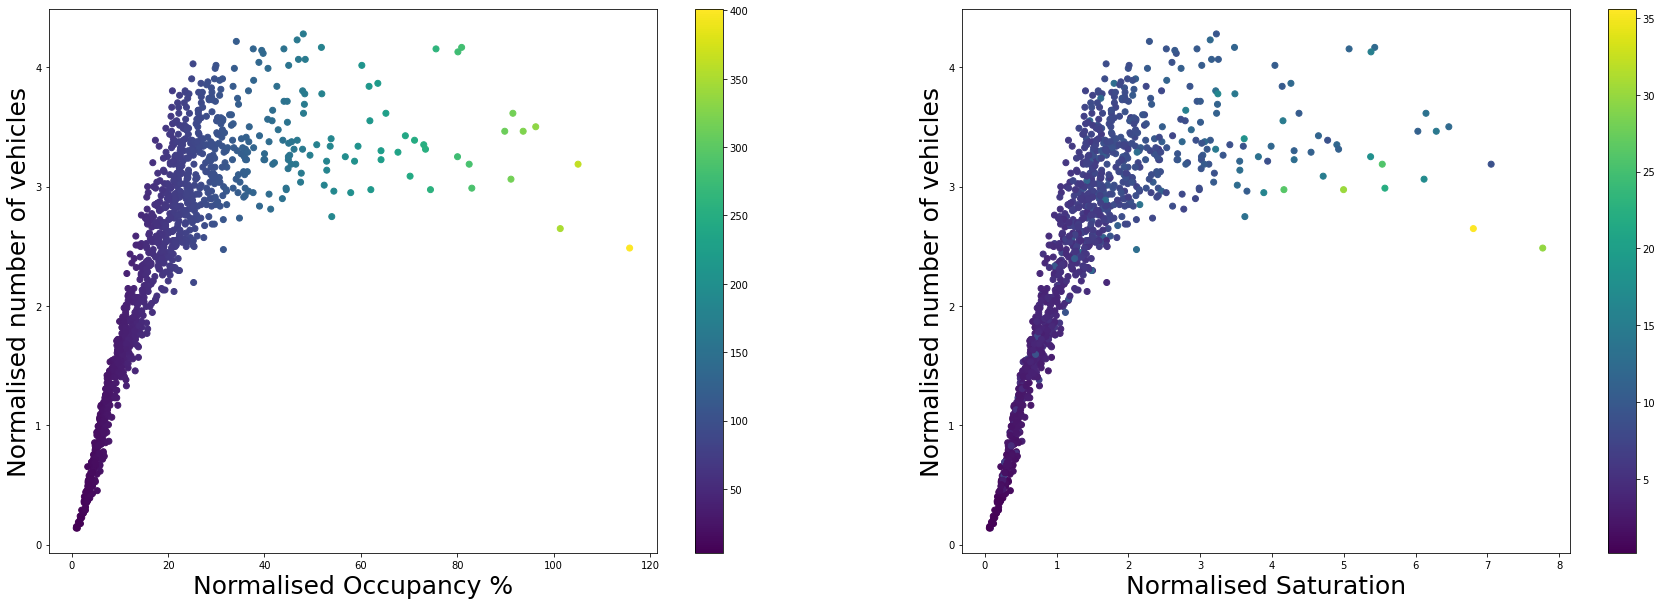

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(30,10))

plt.subplot(1,2,1)
plt.scatter(y=scoot.n_vehicles_in_interval_norm,x=scoot.occupancy_percentage_norm,c=scoot.saturation)
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Occupancy %',fontsize=25)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y=scoot.n_vehicles_in_interval_norm,x=scoot.saturation_norm,c=scoot.occupancy_percentage)
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Saturation',fontsize=25)
plt.colorbar()

# Model assessment via Marginal Likelihood Estimation

We look at [this paper](https://www.sciencedirect.com/science/article/pii/S0167947309002722) and implement a population MCMC for marginal likelihood estimation.

In [302]:
# Parameter values
alpha_guess = 0.6
beta_guess = 0.06

# Estimated q_hat based on deterministic rho
q_hat = log_exponential_fd([alpha_guess,beta_guess])

## Define temperature schedules

In [398]:
# Uniform geometric-based temperature schedule
def uniform_t(_n):
    return np.array([i/_n for i in range(_n+1)]).reshape((_n+1,1))

# Prior geometric-based temperature schedule
def prior_t(_n,_p):
    return np.array([(i/_n)**_p for i in range(_n+1)]).reshape((_n+1,1))

# Posterior geometric-based temperature schedule
def posterior_t(_n,_p):
    return np.array([(1-(i/_n)**_p) for i in range(_n+1)]).reshape((_n+1,1))

def exponential_fd_log_prior(p,t):
    return np.sum([ss.beta.logpdf(p[t,i],prior_alpha,prior_beta) for i in range(num_params)])

def exponential_fd_log_likelihood(p,t,y,sigma_2):
    return ss.multivariate_normal.logpdf(y,exponential_fd(p[t,:]),np.eye(y.shape[0])*sigma_2)

def exponential_fd_log_target(p,y,temp,t,sigma_2):
    # Log target is sum of priors and likelihood for each temperature
    return log_exponential_fd_prior(p,t) + temp[t]*log_exponential_fd_likelihood(p,t,y,sigma_2)

def gaussian_transition_kernel(p_prev,sigma_2):
    # Propose move
    p_new = p_prev + np.random.normal(0,sigma_2**0.5,1)
    # Reflect off boundaries
    for j in range(num_params):
        if p_new[j] < 0.:
            p_new[j] = -p_new[j]
        if p_new[j] > 1.:
            p_new[j] = 1. - (p_new[j] - 1.)
    return p_new
    

def gaussian_transition_kernel_density(p_prev,p_new,t,sigma_2):
    return ss.multivariate_normal.logpdf(p_new[t,:],p_prev[t,:],np.eye(num_params)*sigma_2)

def exponential_fd_log_mutation_mh_acceptance_ratio(p_prev,p_new,t,y,temp,sigma_2):
    numerator = exponential_fd_log_prior(p_new,t) + temp[t]*exponential_fd_log_likelihood(p_new,t,y,sigma_2) #+ gaussian_transition_kernel_density(p_new,p_prev,t,sigma_2)
    denominator =  exponential_fd_log_prior(p_prev,t) + temp[t]*exponential_fd_log_likelihood(p_prev,t,y,sigma_2) #+ gaussian_transition_kernel_density(p_prev,p_new,t,sigma_2)
    return numerator - denominator

def exponential_fd_log_exchange_mh_acceptance_ratio(p_prev,p_new,ti,tj,y,temp,sigma_2):
    numerator = temp[ti]*exponential_fd_log_likelihood(p_new,ti,y,sigma_2)\
                + temp[tj]*exponential_fd_log_likelihood(p_new,tj,y,sigma_2)
#                 + gaussian_transition_kernel_density(p_new,p_prev,ti,sigma_2)\
#                 + gaussian_transition_kernel_density(p_new,p_prev,tj,sigma_2)
    denominator = temp[ti]*exponential_fd_log_likelihood(p_prev,ti,y,sigma_2)\
                  + temp[tj]*exponential_fd_log_likelihood(p_prev,tj,y,sigma_2)
#                   + gaussian_transition_kernel_density(p_prev,p_new,ti,sigma_2)\
#                   + gaussian_transition_kernel_density(p_prev,p_new,tj,sigma_2)
    return numerator - denominator


In [405]:
def population_mcmc(log_target,kernel,temp_schedule,init_params,y,sigma_2,transition_sigma_2,n_iterations,p_mutation,seed=None,print_stat:bool=False):
    
    # Fix random seed
    np.random.seed(seed)
    
    # Store length of temperature schedule
    t_len = temp_schedule.shape[0]
    
    # Initialise sample array
    theta = np.zeros((n_iterations,t_len,init_params.shape[1]))
    
    # Initiliase acceptance rate and proposal counter for mutation and crossover
    prop = np.zeros(3) # 0: mutation, 1: crossover, 2: exchange
    acc = np.zeros(3)
    
    # Define parameter initialisation
    theta_prev = init_params
    
    for ni in tqdm(range(n_iterations)):
        # Randomly pick between local and crossover move
        if np.random.uniform(0,1,1) <= p_mutation:
            # Local mutation move
            prop[0] += 1
            
            # Select random temperature from schedule
            random_t_index = random.choice(range(0,t_len))
            
            # Propose local mutation move
            theta_new = copy.deepcopy(theta_prev)
            theta_new[random_t_index,:] = kernel(theta_prev[random_t_index,:],transition_sigma_2)
            
            # Compute log Metropolis Hasting acceptance ratio for mutation
            log_mutation_acc_ratio = exponential_fd_log_mutation_mh_acceptance_ratio(theta_prev,theta_new,random_t_index,y,temp_schedule,sigma_2)
        
            if print_stat: print('mutation acceptance ratio',min(np.exp(log_mutation_acc_ratio),1))
#             print('mutation_acc_ratio',np.exp(log_mutation_acc_ratio))

            # Accept/reject local mutation proposal
            if min(np.exp(log_mutation_acc_ratio),1) >= np.random.uniform(0,1,1):
                # Accept
                theta_prev = theta_new
                acc[0] += 1
                if print_stat: print('accepted mutation',theta_new)
                
        else:
            # Crossover move
            prop[1] += 1
            
            # Randomly select two chains indices
            random_t_index_i = random.choice(range(0,t_len))
            random_t_index_j = random.choice(range(0,t_len))
            
            # Randomly select crossover point
            c = random.choice(range(0,num_params)) # Paper suggests num_params-1 instead of num_params
            
            # Perform crossover move
            theta_new = copy.deepcopy(theta_prev)
            theta_new[random_t_index_i,c:] = theta_prev[random_t_index_j,c:]
            theta_new[random_t_index_j,c:] = theta_prev[random_t_index_i,c:]
    
            if print_stat:  print(f'Crossover between {random_t_index_i} and {random_t_index_j} at point {c}')

            # Compute log Metropolis Hasting acceptance ratio for crossover
            log_crossover_acc_ratio = exponential_fd_log_exchange_mh_acceptance_ratio(theta_prev,theta_new,random_t_index_i,random_t_index_j,y,temp_schedule,sigma_2)

            if print_stat:  print('crossover acceptance ratio',min(np.exp(log_crossover_acc_ratio),1))

            # Accept/reject crossover proposal
            if min(np.exp(log_crossover_acc_ratio),1) >= np.random.uniform(0,1,1):
                # Accept
                theta_prev = theta_new
                acc[1] += 1
                if print_stat: print('accepted crossover',theta_new)
                
        
        # Global exchange move
        prop[2] += 1
        
        # Randomly select a chains index
        random_t_index = random.choice(range(0,t_len))
        # Get adjacent chain
        exchange_t_index = random_t_index + 1
        # If current chain is the last then select the first chain as adjacent
        if random_t_index == t_len-1:
            exchange_t_index = 0
        
        # Perform global exchange move
        theta_new = copy.deepcopy(theta_prev)
        theta_new[random_t_index,:] = theta_prev[exchange_t_index,:]
        theta_new[exchange_t_index,:] = theta_prev[random_t_index,:]

        if print_stat:  print(f'Exchange between {random_t_index} and {exchange_t_index}')
#         print(f'Exchange between {random_t_index} and {exchange_t_index}')
        
#         print('theta_prev == theta_new',theta_prev == theta_new)
    
        # Compute log Metropolis Hasting acceptance ratio for crossover
        log_exchange_acc_ratio = exponential_fd_log_exchange_mh_acceptance_ratio(theta_prev,theta_new,random_t_index,exchange_t_index,y,temp_schedule,sigma_2)

        if print_stat:  print('exchange acceptance ratio',min(np.exp(log_exchange_acc_ratio),1))
#         print('exchange acceptance ratio',np.exp(log_exchange_acc_ratio))

        # Accept/reject exchange proposal
        if min(np.exp(log_exchange_acc_ratio),1) >= np.random.uniform(0,1,1):
            # Accept
            theta_prev = theta_new
            acc[2] += 1
            if print_stat: print('accepted exchange',theta_new)
        
        
        # Append sample to array
        theta[ni,:,:] = theta_prev
            
    
    return theta, np.divide(acc,prop)

In [406]:
# Fix random seed
np.random.seed(2021)

# Define power
p = 5
# Define number of parameters
num_params = 2
# Define parameter names
param_names = [r'$\alpha$',r'$\beta$']
# Define number of disretisations of [0,1] interval
n = 20
# Define number of iterations of each temperature chain
N = 1000
# Define observation variance
sigma2 = 1
# Define transition kernel variance
transition_sigma2 = 0.2
# Prior alpha for parameters
prior_alpha = 1
# Prior beta for parameters
prior_beta = 2
# Set mutation probability for proposing local move instead of crossover move
pm = 1
# Define temperature schedule
temperature_schedule = prior_t(n,p)

# Generate pairs of (alpha,beta) from Beta(1,2) prior
parameters_init = np.zeros((n+1,num_params))
parameters_init[:,0] = np.array([a for a in np.random.beta(prior_alpha,prior_beta,n+1)])
parameters_init[:,1] = np.array([b for b in np.random.beta(prior_alpha,prior_beta,n+1)])

In [407]:
pop_mcmc_parameters,pop_mcmc_acceptances = population_mcmc(log_exponential_fd_target,gaussian_transition_kernel,temperature_schedule,parameters_init,q,sigma2,transition_sigma2,N,pm)

print('Population MCMC')
print(f'Mutation acceptance rate {int(pop_mcmc_acceptances[0]*100)}%')
if pm < 1:
    print(f'Crossover acceptance rate {int(pop_mcmc_acceptances[1]*100)}%')
print(f'Exchange acceptance rate {int(pop_mcmc_acceptances[2]*100)}%')

100%|██████████| 1000/1000 [12:54<00:00,  1.29it/s]

Population MCMC
Mutation acceptance rate 23%
Exchange acceptance rate 53%



/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in true_divide


## Inspect samples 

In [420]:
# Find index of largest temperature (corresponding to posterior measure)
highest_temp_idx = np.argmax(temperature_schedule)

# Select temperature to inspect samples for
temp_choice = highest_temp_idx

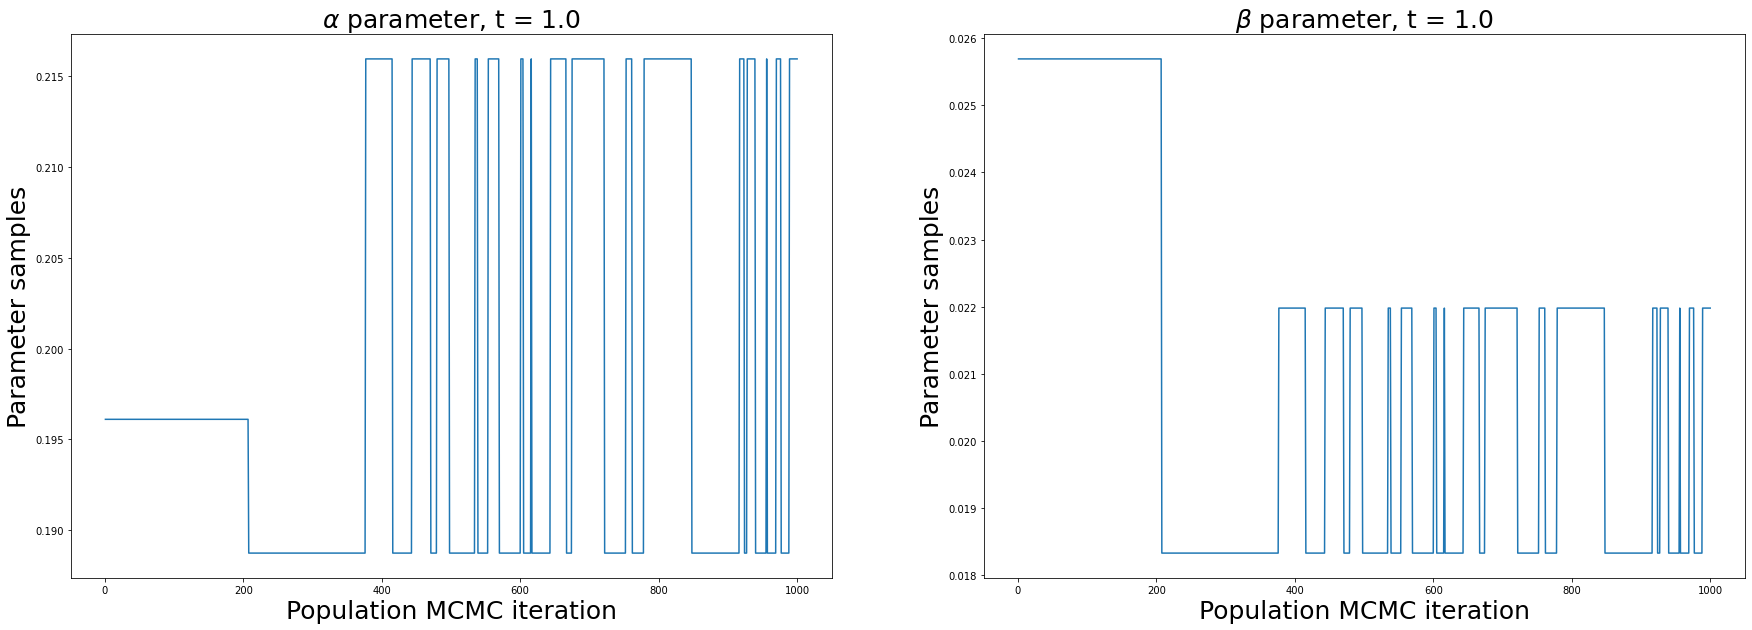

In [422]:
fig, ax = plt.subplots(nrows=1, ncols=num_params,figsize=(30,10))

for i in range(1,num_params+1):
    plt.subplot(1,num_params,i)
    plt.title(f'{param_names[i-1]} parameter, t = {prior_t(n,p)[temp_choice][0]}',fontsize=25)
    plt.plot(range(1,N+1),pop_mcmc_parameters[:,temp_choice,i-1],label='Sampled chains')
    plt.ylabel('Parameter samples',fontsize=25)
    plt.xlabel('Population MCMC iteration',fontsize=25)
#     plt.legend(fontsize=20)


## Compute log marginal likelihood

The log marginal likelihood is equal to 

$$\log(Z_t) = \sum_{i=1}^n \log(Z_{t_{i}})$$

and is calculated from

$$\log(p(\mathbf{y})) = \lim_{\Delta t \to 0} \sum_{i=1}^n  \mathbb{E}_{\theta|\mathbf{y},t_i}\left[\log(p(\mathbf{y}|\theta)\right] \Delta t \approx  \sum_{i=1}^n \sum_{j=1}^N \log(p(\mathbf{y}|\theta_i^{(j)}) \Delta t$$

where $\theta_i^{(j)}$ are samples from the population MCMC-inferred posterior $p(\theta|\mathbf{y},t_i)$.


In [429]:
def exponential_fd_log_marginal_likelihood(learned_params,y,temp_schedule,sigma_2):
    
    # Store length of temperature schedule
    t_len = temp_schedule.shape[0]
    
    # Get number of MCMC iterations
    num_iters = learned_params.shape[0]
    
    # Initiliase lml 
    lml = 0    
#     return np.sum([(temp_schedule[ti] - temp_schedule[ti-1]) * np.sum([exponential_fd_log_likelihood(learned_params[j,:,:],ti,y,sigma_2) for ti in range(1,t_len) for j in range(num_iters)])])
    
    # Loop temperature indices
    for ti in tqdm(range(1,t_len)):
        # Compute Delta t
        delta_t = temp_schedule[ti] - temp_schedule[ti-1]
        
        # Loop through each iteration
        for j in range(num_iters):
            # Compute posterior expectation
            lml += delta_t * exponential_fd_log_likelihood(learned_params[j,:,:],ti,y,sigma_2)
    
    return lml

In [430]:
exponential_fd_lml = exponential_fd_log_marginal_likelihood(pop_mcmc_parameters,q,temperature_schedule,sigma2)

100%|██████████| 20/20 [41:16<00:00, 123.84s/it]


In [431]:
exponential_fd_lml

array([-1777601.38085457])